In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import matplotlib.pyplot as plt
from matplotlib import gridspec

2024-02-17 11:15:08.103701: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
ds_train = image_dataset_from_directory(
    '../cifar-10-stable-diffusion-detection/train',
    labels='inferred',
    label_mode='binary',
    image_size=[64,64],
    interpolation='nearest',
    batch_size=32,
    shuffle=True,
    seed=69,
    #validation_split=None,
    subset=None,
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 100000 files belonging to 2 classes.


In [4]:
ds_test = image_dataset_from_directory(
    '../cifar-10-stable-diffusion-detection/test',
    labels='inferred',
    label_mode='binary',
    image_size=[64,64],
    interpolation='nearest',
    batch_size=32,
    shuffle=True,
    seed=69,
    #validation_split=None,
    subset=None,
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 20000 files belonging to 2 classes.


In [5]:
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE


In [6]:
ds_train = (
    ds_train
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


In [7]:
ds_valid = (
    ds_test
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [8]:
model = keras.Sequential([
    layers.InputLayer(input_shape=[64, 64, 3]),
    
    # Data Augmentation
    
    preprocessing.RandomFlip(mode='horizontal'),
    preprocessing.RandomRotation(factor=0.05), 


    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

In [9]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

Epoch 1/50
3125/3125 [==============================] - 152s 48ms/step - loss: 0.3090 - binary_accuracy: 0.8623 - val_loss: 0.2522 - val_binary_accuracy: 0.8948
Epoch 2/50
3125/3125 [==============================] - 149s 48ms/step - loss: 0.2140 - binary_accuracy: 0.9142 - val_loss: 0.2219 - val_binary_accuracy: 0.9110
Epoch 3/50
3125/3125 [==============================] - 146s 47ms/step - loss: 0.1934 - binary_accuracy: 0.9235 - val_loss: 0.1904 - val_binary_accuracy: 0.9225
Epoch 4/50
3125/3125 [==============================] - 144s 46ms/step - loss: 0.1817 - binary_accuracy: 0.9280 - val_loss: 0.1857 - val_binary_accuracy: 0.9244
Epoch 5/50
3125/3125 [==============================] - 143s 46ms/step - loss: 0.1740 - binary_accuracy: 0.9308 - val_loss: 0.1677 - val_binary_accuracy: 0.9332
Epoch 6/50
3125/3125 [==============================] - 144s 46ms/step - loss: 0.1676 - binary_accuracy: 0.9344 - val_loss: 0.1716 - val_binary_accuracy: 0.9319
Epoch 7/50
3125/3125 [============

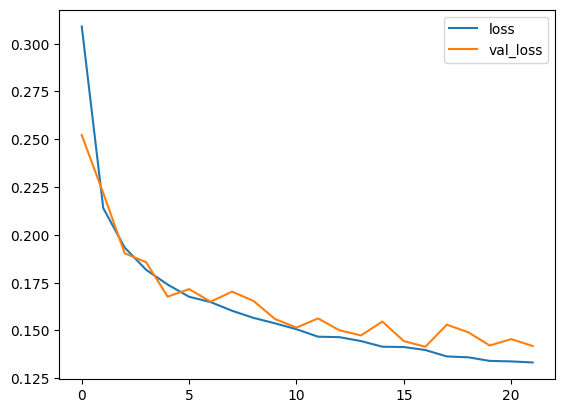

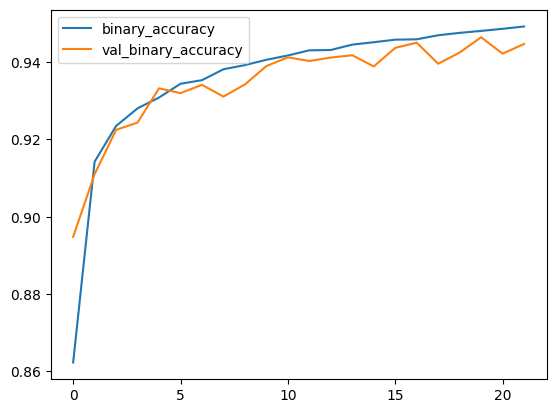

In [10]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
    callbacks=[early_stopping],
)

# Plot learning curves
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
